<a href="https://colab.research.google.com/github/arunav93/Capstone-Project---Seoul-Bike-Sharing-Demand-Prediction/blob/main/Seoul_Bike_Sharing_Demand_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Seoul Bike Sharing Demand Prediction </u></b>

## <b> Problem Description </b>

### Currently Rental bikes are introduced in many urban cities for the enhancement of mobility comfort. It is important to make the rental bike available and accessible to the public at the right time as it lessens the waiting time. Eventually, providing the city with a stable supply of rental bikes becomes a major concern. The crucial part is the prediction of bike count required at each hour for the stable supply of rental bikes.


## <b> Data Description </b>

### <b> The dataset contains weather information (Temperature, Humidity, Windspeed, Visibility, Dewpoint, Solar radiation, Snowfall, Rainfall), the number of bikes rented per hour and date information.</b>


### <b>Attribute Information: </b>

* ### Date : year-month-day
* ### Rented Bike count - Count of bikes rented at each hour
* ### Hour - Hour of he day
* ### Temperature-Temperature in Celsius
* ### Humidity - %
* ### Windspeed - m/s
* ### Visibility - 10m
* ### Dew point temperature - Celsius
* ### Solar radiation - MJ/m2
* ### Rainfall - mm
* ### Snowfall - cm
* ### Seasons - Winter, Spring, Summer, Autumn
* ### Holiday - Holiday/No holiday
* ### Functional Day - NoFunc(Non Functional Hours), Fun(Functional hours)

# Loading Dataset and Importing Modules

In [62]:
# importing the modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math 
from statsmodels.stats.outliers_influence import variance_inflation_factor


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import log_loss

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
font = {'family' : 'normal',
        'size'   : 16}
plt.rc('font', **font)

## Mount the drive and import the datset

In [63]:
# Mount your drive and read the csv file. Make sure you are using the correct file path
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
# loading csv File
file_path = '/content/drive/MyDrive/AlmaBetter/ALMA DATASETS/SeoulBikeData.csv'
df=pd.read_csv(file_path, encoding='cp1252')

## Common Functions

In [65]:
# define global variable
model_scores_dict = {}

def regression_line_plot(df, col,dependent_variable):
  fig = plt.figure(figsize=(9, 6))
  ax = fig.gca()
  feature = df[col]
  label = df[dependent_variable]
  correlation = feature.corr(label)
  plt.scatter(x=feature, y=label)
  plt.xlabel(col)
  plt.ylabel(dependent_variable)
  ax.set_title(dependent_variable+' vs '+col+' - correlation: ' + str(correlation))
  z = np.polyfit(df[col], df[dependent_variable], 1)
  y_hat = np.poly1d(z)(df[col])
  plt.plot(df[col], y_hat, "r--", lw=1)

def histogram(df, col):
  fig = plt.figure(figsize=(9, 6))
  ax = fig.gca()
  feature = df[col]
  feature.hist(bins=50, ax = ax)
  ax.axvline(feature.mean(), color='magenta', linestyle='dashed', linewidth=2)
  ax.axvline(feature.median(), color='cyan', linestyle='dashed', linewidth=2)    
  ax.set_title(col)

def evaluation_metrics(model, X, y, predicted_values ):
  #calculate MSE
  MSE_d= mean_squared_error(y, predicted_values)

  #calculate RMSE
  RMSE_d=np.sqrt(MSE_d)

  #calculate MAE
  MAE_d= mean_absolute_error(y, predicted_values)

  #calculate r2 and adjusted r2
  r2_d= r2_score(y, predicted_values)
  adjusted_r2_linear_reg_train = (1-(1-r2_score(y, predicted_values))*((X.shape[0]-1)/(X.shape[0]-X.shape[1]-1)) )
  return {
      'MSE'         : MSE_d,
      'RMSE'        : RMSE_d,
      'MAE'         : MAE_d,
      'R2'          : r2_d,
      'Adjusted R2' : adjusted_r2_linear_reg_train
  }

def show_evaluation_metrics(score_dict):
  for key, value in score_dict.items():
    print(key,' : ',value)

def save_model_scores(model_name, train_model_score, test_model_score):
  global model_scores_dict
  model_score = {}

  for key, value in test_model_score.items():
    model_score['Test_'+key] = value

  for key, value in train_model_score.items():
    model_score['Train_'+key] = value


  model_scores_dict[model_name] = model_score       #

def model_evaluation_show_and_save(model, model_name, X, y_train,y_test, predicted_values_train, predicted_values_test):
  train_score = evaluation_metrics(model, X, y_train, predicted_values_train)
  print('For Train Data: ')
  show_evaluation_metrics(train_score)

  print("-"*40)

  test_score = evaluation_metrics(model, X, y_test, predicted_values_test)
  print('For Test Data: ')
  show_evaluation_metrics(test_score)

  save_model_scores(model_name, train_score, test_score)


# Understand More About The Data

##summary of data

In [66]:
# View top 5 rows of the data
df.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [67]:
# View bottom 5 rows of the data
df.tail()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
8755,30/11/2018,1003,19,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,Autumn,No Holiday,Yes
8756,30/11/2018,764,20,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
8757,30/11/2018,694,21,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
8758,30/11/2018,712,22,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,Autumn,No Holiday,Yes
8759,30/11/2018,584,23,1.9,43,1.3,1909,-9.3,0.0,0.0,0.0,Autumn,No Holiday,Yes


In [68]:
# get the shape of the data
shape = df.shape
print(f"There are total {shape[0]} rows and {shape[1]} columns.")

There are total 8760 rows and 14 columns.


In [69]:
# get all column names
columns = list(df.columns)
columns

['Date',
 'Rented Bike Count',
 'Hour',
 'Temperature(°C)',
 'Humidity(%)',
 'Wind speed (m/s)',
 'Visibility (10m)',
 'Dew point temperature(°C)',
 'Solar Radiation (MJ/m2)',
 'Rainfall(mm)',
 'Snowfall (cm)',
 'Seasons',
 'Holiday',
 'Functioning Day']

In [70]:
# get details of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8760 non-null   object 
 1   Rented Bike Count          8760 non-null   int64  
 2   Hour                       8760 non-null   int64  
 3   Temperature(°C)            8760 non-null   float64
 4   Humidity(%)                8760 non-null   int64  
 5   Wind speed (m/s)           8760 non-null   float64
 6   Visibility (10m)           8760 non-null   int64  
 7   Dew point temperature(°C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)    8760 non-null   float64
 9   Rainfall(mm)               8760 non-null   float64
 10  Snowfall (cm)              8760 non-null   float64
 11  Seasons                    8760 non-null   object 
 12  Holiday                    8760 non-null   object 
 13  Functioning Day            8760 non-null   objec

In [71]:
# get the description of the numerical data
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Rented Bike Count,8760.0,704.602055,644.997468,0.0,191.00,504.50,1065.25,3556.00
Hour,8760.0,11.500000,6.922582,0.0,5.75,11.50,17.25,23.00
Temperature(°C),8760.0,12.882922,11.944825,-17.8,3.50,13.70,22.50,39.40
Humidity(%),8760.0,58.226256,20.362413,0.0,42.00,57.00,74.00,98.00
Wind speed (m/s),8760.0,1.724909,1.036300,0.0,0.90,1.50,2.30,7.40
Visibility (10m),8760.0,1436.825799,608.298712,27.0,940.00,1698.00,2000.00,2000.00
Dew point temperature(°C),8760.0,4.073813,13.060369,-30.6,-4.70,5.10,14.80,27.20
Solar Radiation (MJ/m2),8760.0,0.569111,0.868746,0.0,0.00,0.01,0.93,3.52
Rainfall(mm),8760.0,0.148687,1.128193,0.0,0.00,0.00,0.00,35.00
Snowfall (cm),8760.0,0.075068,0.436746,0.0,0.00,0.00,0.00,8.80


In [72]:
# get the description of the categorical data
df.describe(include="object").T

,count,unique,top,freq
Date,8760,365,01/12/2017,24
Seasons,8760,4,Spring,2208
Holiday,8760,2,No Holiday,8328
Functioning Day,8760,2,Yes,8465


# Preprocessing the dataset

## Missing values

In [73]:
#check for count of missing values
df.isna().sum()

Date                         0
Rented Bike Count            0
Hour                         0
Temperature(°C)              0
Humidity(%)                  0
Wind speed (m/s)             0
Visibility (10m)             0
Dew point temperature(°C)    0
Solar Radiation (MJ/m2)      0
Rainfall(mm)                 0
Snowfall (cm)                0
Seasons                      0
Holiday                      0
Functioning Day              0
dtype: int64

* **It can be seen that there are no missing values present in the data.**



## Duplicate values

In [74]:
print(f"The number of duplicate values in the data is {len(df[df.duplicated()])}")

The number of duplicate values in the data is 0


* **It seems that there are no duplicate rows present in the data.**

## Changing column name

* **The column names of the dataset are complicated. So we will make it simpler.**.

In [75]:
# Rename the columns
df.rename(columns = lambda x: x.partition('(')[0].strip(), inplace=True)
list(df.columns)

['Date',
 'Rented Bike Count',
 'Hour',
 'Temperature',
 'Humidity',
 'Wind speed',
 'Visibility',
 'Dew point temperature',
 'Solar Radiation',
 'Rainfall',
 'Snowfall',
 'Seasons',
 'Holiday',
 'Functioning Day']

# Exploratory Data Analysis Of The Data Set

## Analysis of Dependent Variable:

* **In the dataset  "Rented Bike Count"  is the dependent variable. Let's analyze it.**

In [76]:
dependent_variable = "Rented Bike Count"

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


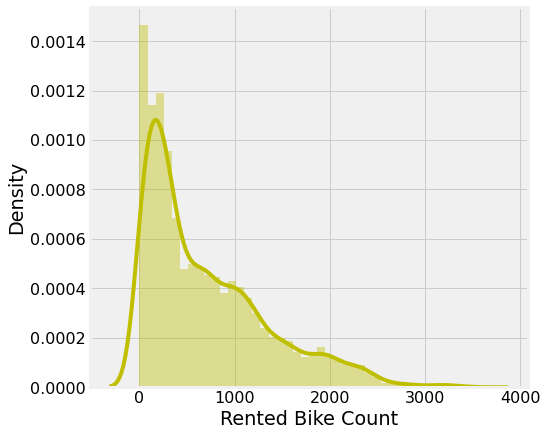

In [77]:
# Let's create a histogram 
plt.figure(figsize=(7,7))
sns.distplot(df[dependent_variable],color="y")

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


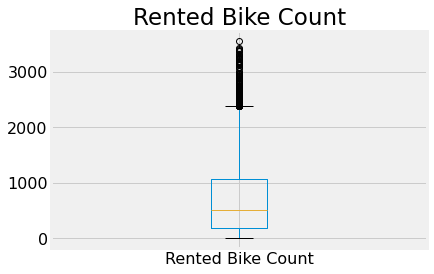

In [78]:
# Let's create a box plot to check outliers
df.boxplot(column=dependent_variable)
plt.title(dependent_variable)
plt.show()

* **From the box plot, we can see  many outliers present in the data.**
* **From the histogram, it is clear that the spread of the data is positively skewed. So, we will use transformation techniques to normalize the data.**

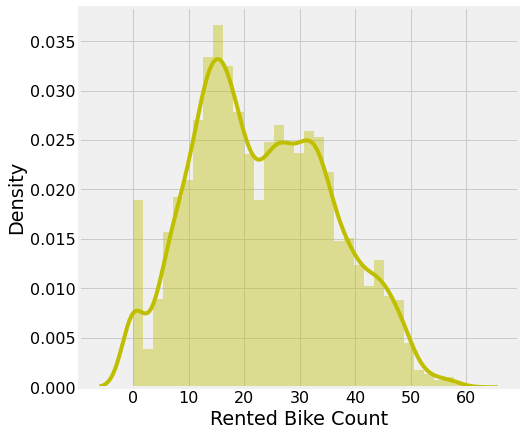

In [79]:
# Let's use square root technique to normalize the data
plt.figure(figsize=(7,7))
df['Rented Bike Count'] = df['Rented Bike Count'].apply(lambda x: math.sqrt(x))
sns.distplot(df['Rented Bike Count'],color="y")

## Analysis of categorical variables

**Let's look at each categorical variable one by one**

### Date

In [80]:
# Let's make date object to datetime
from datetime import datetime
format = '%d/%m/%Y'
df['Date'] = df['Date'].apply(lambda x: datetime.strptime(x,format))

In [81]:
print(f"Total unique values in the Date column is {len(df.Date.unique())}")

Total unique values in the Date column is 365


In [82]:
print(f"The minimum date is {df['Date'].min().date()} and maximum date is {df['Date'].max().date()}")

The minimum date is 2017-12-01 and maximum date is 2018-11-30


* **It can be seen that there are 365 days and for each day there are 24 entries (each hour) totalling 8760 i.e. total no. of rows. But we can't get any valuable information for each day, so instead, we can create another feature that contains a month. Since the starting date is 01/12/2017 and the end date is 30/11/2018, we can neglect the year.**

#### Month

In [83]:
# Ceate a new feature month from date
df['month'] = pd.DatetimeIndex(df['Date']).month
df.head()

,Date,Rented Bike Count,Hour,Temperature,Humidity,Wind speed,Visibility,Dew point temperature,Solar Radiation,Rainfall,Snowfall,Seasons,Holiday,Functioning Day,month
0,2017-12-01,15.937377,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,12
1,2017-12-01,14.282857,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,12
2,2017-12-01,13.152946,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes,12
3,2017-12-01,10.344080,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,12
4,2017-12-01,8.831761,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes,12


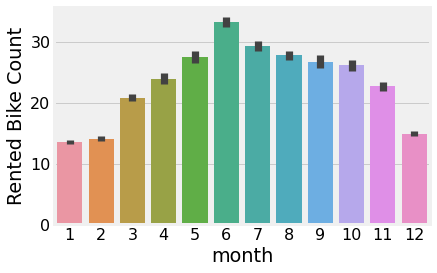

In [84]:
# plot a barplot month vs Rented Bike Count
sns.barplot(x = "month",y = dependent_variable,data = df)

* **It seems that in June rental bike count is highest.**

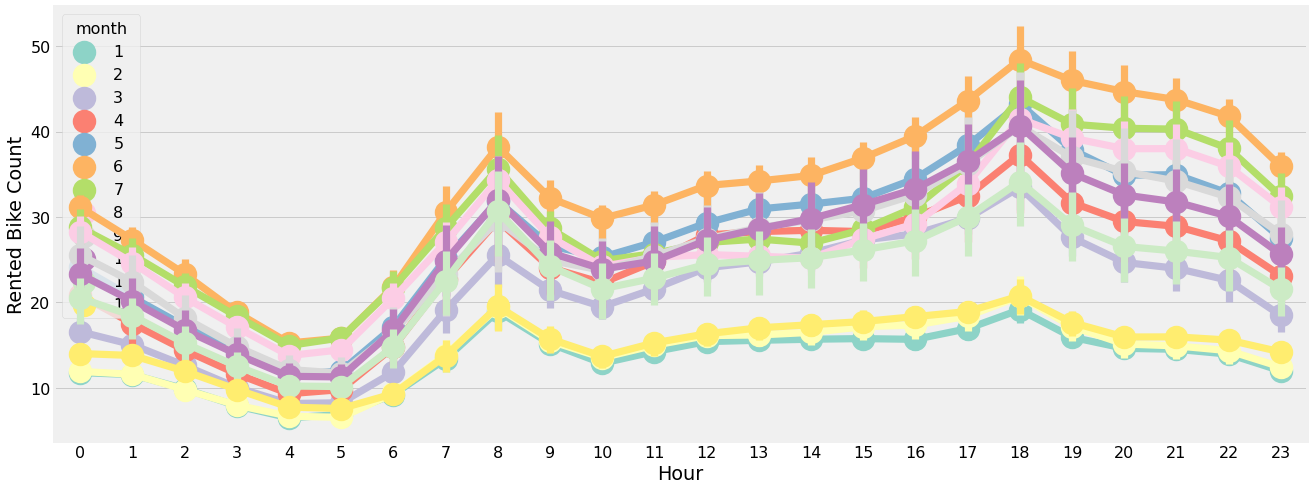

In [85]:
# Rented Bike Count against Hour for weekdays
fig,ax=plt.subplots(figsize=(20,8))
sns.pointplot(x = "Hour",y = dependent_variable, hue="month",data = df, palette="Set3")

* It seems that for the months from December to February (winter season) the bike is lower than the other months.

#### WeekDay

In [86]:
# create weekday variable
df['WeekDay']=df["Date"].dt.day_name() 

In [87]:
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
week_day_wise_bike_count=pd.DataFrame(df.groupby('WeekDay').sum()['Rented Bike Count']).reindex(cats)
week_day_wise_bike_count.style.background_gradient(cmap=sns.light_palette("red", as_cmap=True))

,Rented Bike Count
WeekDay,
Monday,30038.871795
Tuesday,28432.582187
Wednesday,29989.299923
Thursday,28865.309104
Friday,30958.302920
Saturday,29749.618212
Sunday,27330.152056


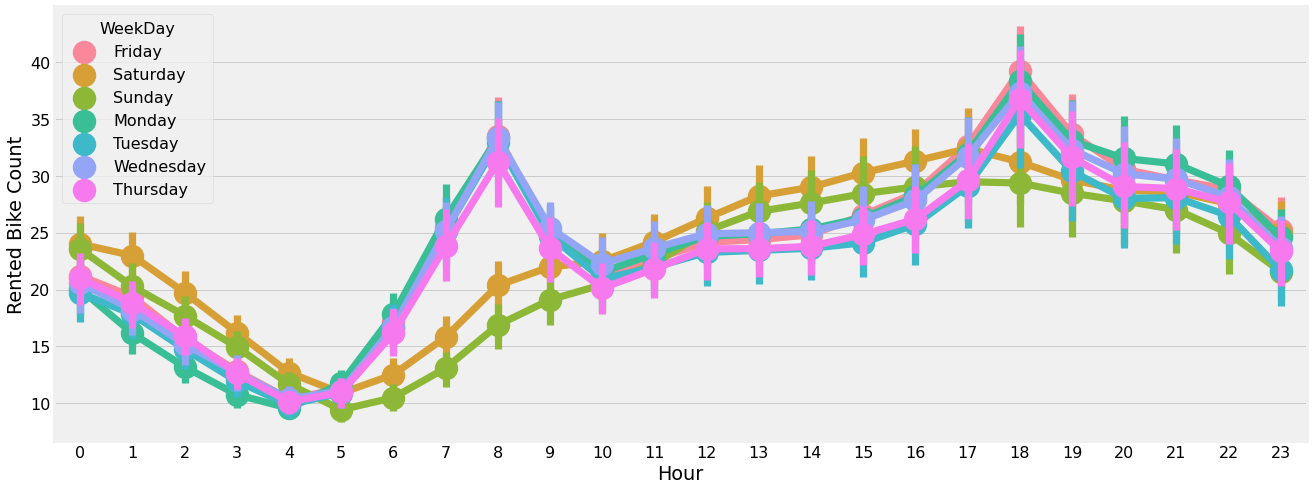

In [88]:
# Rented Bike Count against Hour for weekdays
fig,ax=plt.subplots(figsize=(20,8))
sns.pointplot(x = "Hour",y = dependent_variable, hue="WeekDay",data = df)

* **From the above plot, we can see that there is a different trend for Saturday & Sunday compared to others.**
* **So we can create a new categorical feature where we consider Saturday & Sunday as a weekend.**

#### isWeekend

In [89]:
# create isWeekend variable
df['isWeekend'] = df['WeekDay'].apply(lambda x: 1 if x == 'Saturday' or x == 'Sunday' else 0)

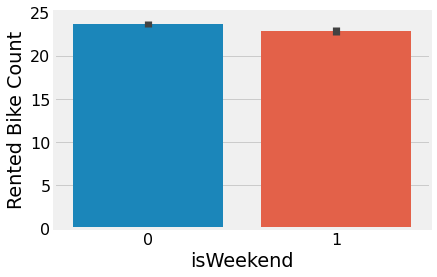

In [90]:
# plot a barplot isWeekend vs Rented Bike Count
sns.barplot(x = "isWeekend",y = dependent_variable,data = df)

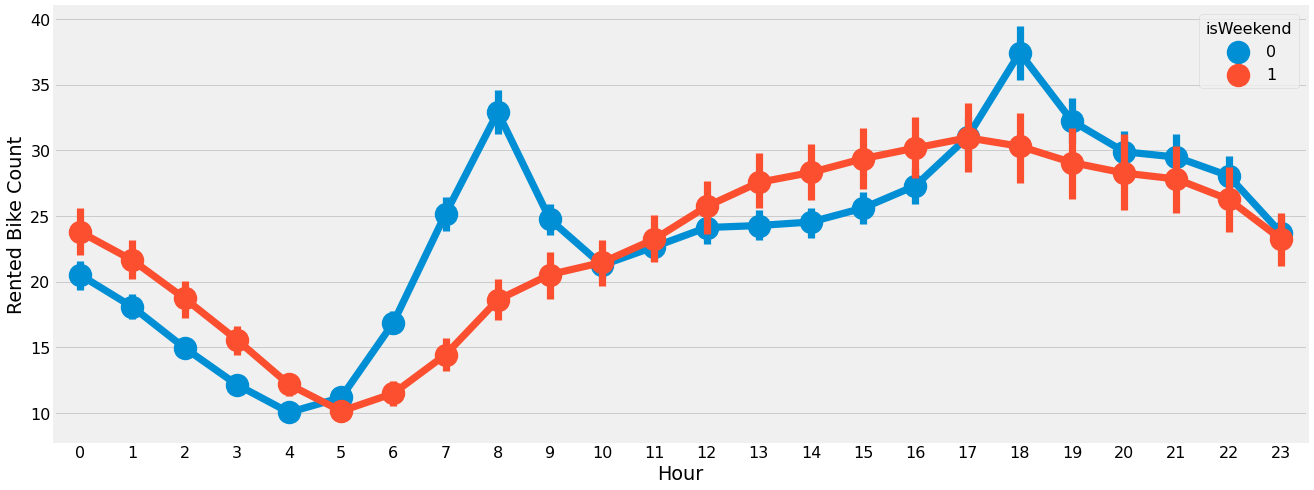

In [91]:
# Rented Bike Count against Hour for isWeekend
fig,ax=plt.subplots(figsize=(20,8))
sns.pointplot(x = "Hour",y = dependent_variable, hue="isWeekend",data = df)

* **Since we see a trend, we will remove WeekDay.**

In [92]:
df.drop(['WeekDay'], axis=1, inplace = True)

In [93]:
df.head()

,Date,Rented Bike Count,Hour,Temperature,Humidity,Wind speed,Visibility,Dew point temperature,Solar Radiation,Rainfall,Snowfall,Seasons,Holiday,Functioning Day,month,isWeekend
0,2017-12-01,15.937377,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,12,0
1,2017-12-01,14.282857,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,12,0
2,2017-12-01,13.152946,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes,12,0
3,2017-12-01,10.344080,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,12,0
4,2017-12-01,8.831761,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes,12,0


### Seasons

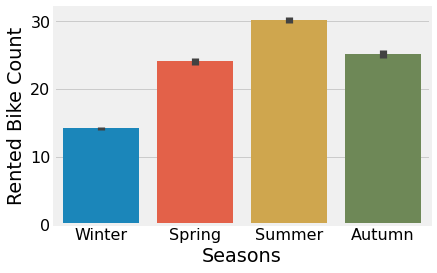

In [94]:
# plot a barplot season vs Rented Bike Count
#fig,ax=plt.subplots(figsize=(20,8))
sns.barplot(x = "Seasons",y = dependent_variable,data = df)

Let's check the trend for seasonwise bike count for each hour.

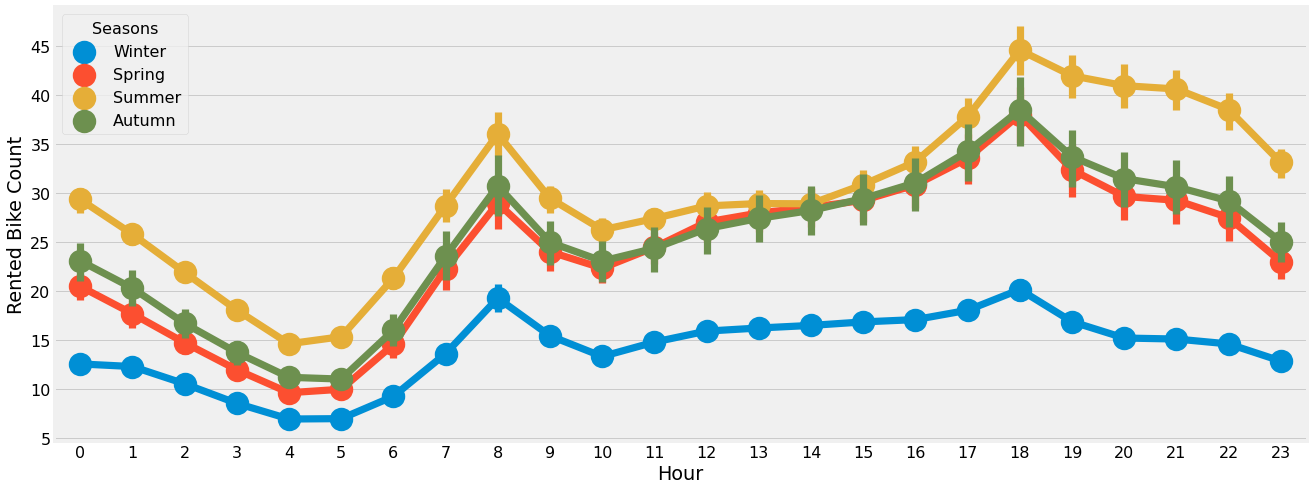

In [95]:
# Rented Bike Count against Hour for each seasons
fig,ax=plt.subplots(figsize=(20,8))
sns.pointplot(x = "Hour",y = dependent_variable, hue="Seasons",data = df)

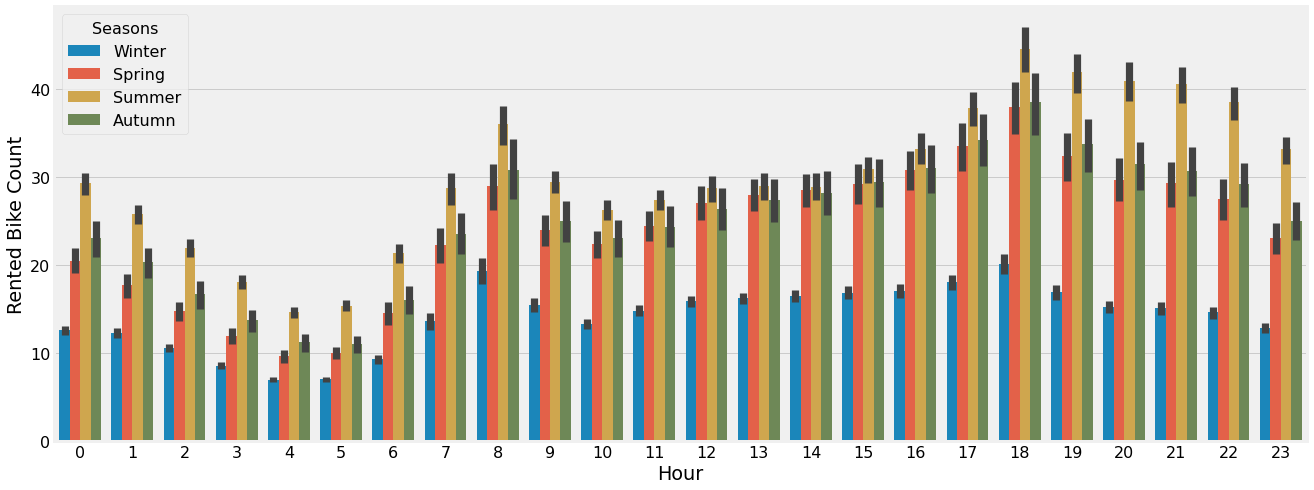

In [96]:
# Rented Bike Count against Hour for each season 
fig,ax=plt.subplots(figsize=(20,8))
sns.barplot(x = "Hour",y = dependent_variable, hue="Seasons",data = df)

**From the above plot, we can conclude that**
*   **For winter bike count is the lowest.**
*   **For summer bike count is the highest.**



### Holiday

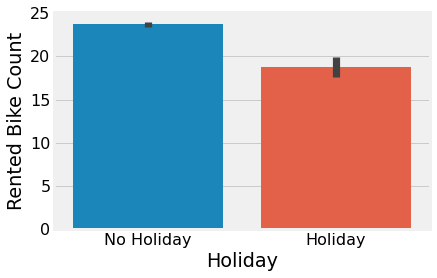

In [97]:
# plot a barplot Holiday vs Rented Bike Count
sns.barplot(x = "Holiday",y = dependent_variable,data = df)

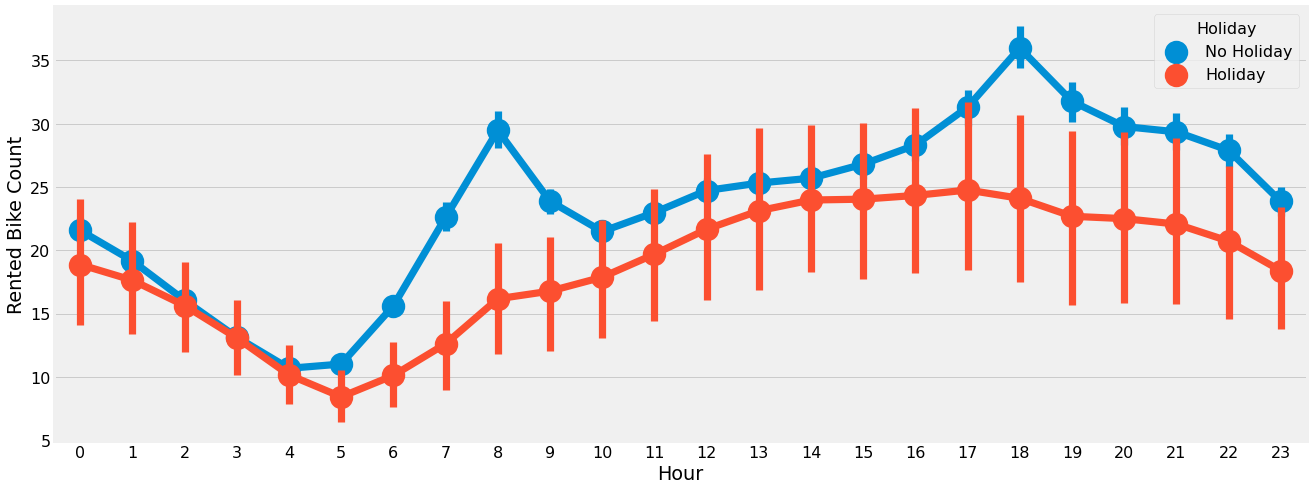

In [98]:
fig,ax=plt.subplots(figsize=(20,8))
sns.pointplot(x = "Hour",y = dependent_variable, hue="Holiday",data = df)

* **From the above plot, we can see that the rented bike count is lower on holidays compared to the working day.**
* **On working days from 7-9 AM and 5-7 PM, there is a sudden spike.** 

### Functioning Day

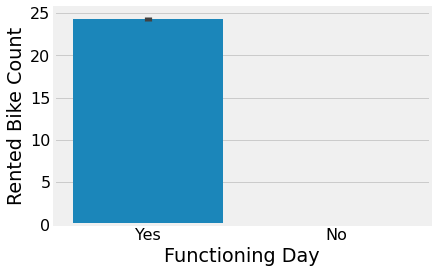

In [99]:
# plot a barplot Functioning Day vs Rented Bike Count
sns.barplot(x = "Functioning Day",y = dependent_variable,data = df)

In [100]:
non_functioning_day_df = df[df['Functioning Day'] == "No"]
mean_bike_count = non_functioning_day_df[dependent_variable].mean()
print(f"Mean value of bike count for non functioning day(hour) is {mean_bike_count}")
print(f"Total rows with non functioning day(hour) is {len(non_functioning_day_df)}")

Mean value of bike count for non functioning day(hour) is 0.0
Total rows with non functioning day(hour) is 295


*   **It can be seen that for non functioning day(hour) the bike count is 0. It means for that hour the service is discontinued which is why the total rented bike count is 0. So, we can remove the rows in which the value is "No" and since the remaining data points have the same value (i.e. "Yes") we choose to drop the "Functioning Day" column.**

In [101]:
# save previous rows
previous_rows = df.shape[0]

In [102]:
# removing the rows of "Functioning Day" with "No" values
df.drop(df[df['Functioning Day'] == 'No'].index, inplace = True)
print(f"Rows before deletion is {previous_rows} and after deletion is {df.shape[0]}")

Rows before deletion is 8760 and after deletion is 8465


In [103]:
# Let's drop the column Functioning Day
df.drop(['Functioning Day'], axis=1, inplace = True)
list(df.columns)

['Date',
 'Rented Bike Count',
 'Hour',
 'Temperature',
 'Humidity',
 'Wind speed',
 'Visibility',
 'Dew point temperature',
 'Solar Radiation',
 'Rainfall',
 'Snowfall',
 'Seasons',
 'Holiday',
 'month',
 'isWeekend']

## Analysis of Numerical variables

### Hour

[Text(0.5, 1.0, 'Rented bikes counts acording to Hour')]

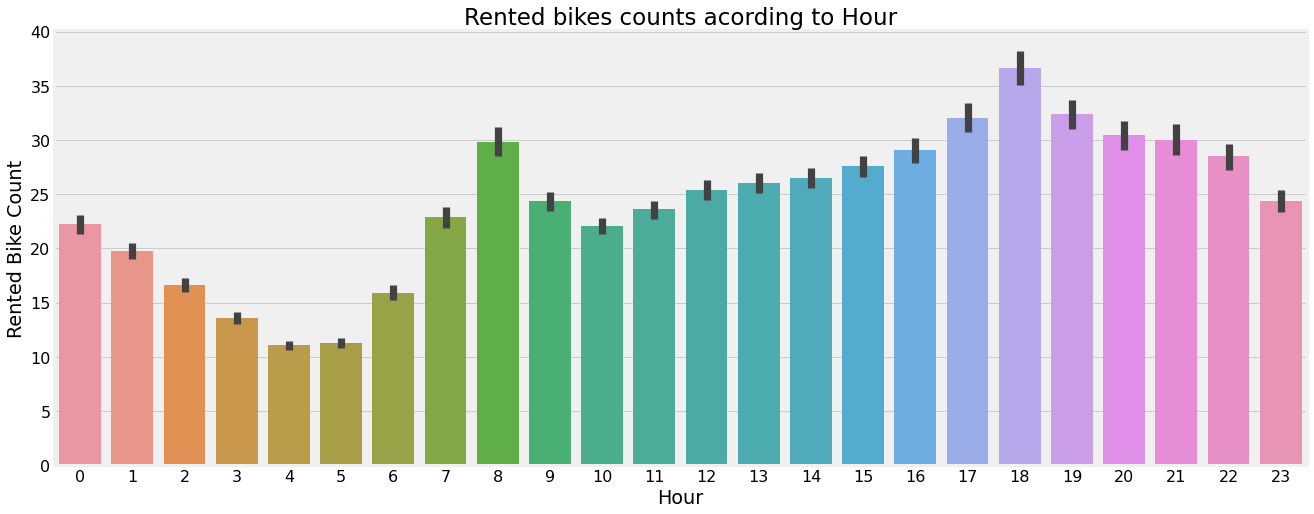

In [104]:
# 
fig,ax=plt.subplots(figsize=(20,8))
sns.barplot(data=df,x='Hour',y=dependent_variable)
ax.set(title='Rented bikes counts acording to Hour')

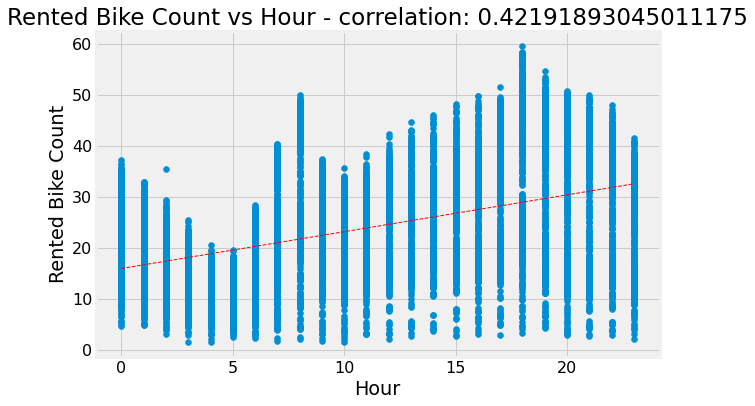

In [105]:
# find the correlation of Hour with the dependent variable
col = "Hour"
regression_line_plot(df, col, dependent_variable)

* **There is a correlation between Hour and Rented bike count.**
* **7-9 AM and 5-7 PM, there is a sudden spike in bike count. So we can create a new categorical feature where we take 7 AM to 7 PM as a working hour.**

#### isWorkingHour

In [106]:
df['isWorkingHour']=df['Hour'].apply(lambda x : 0 if (x >19 or x<8) else 1)

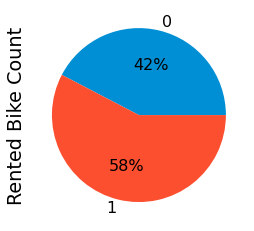

In [107]:
df.groupby('isWorkingHour').sum()['Rented Bike Count'].plot.pie(autopct='%.0f%%')

* **During working hours (i.e. 7 AM to 7 PM) rented bike count is high (i.e. 63%) compared to not working hours (i.e. 37%).**

### Temperature

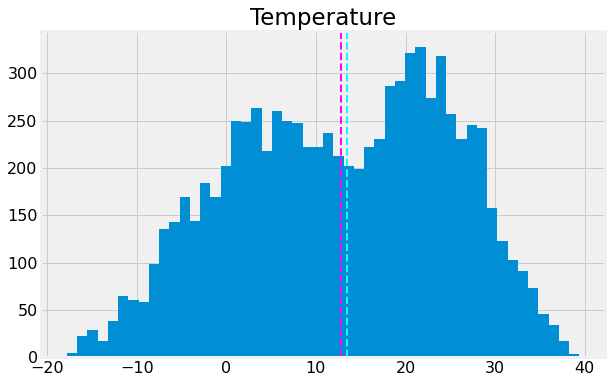

In [108]:
# check the distribution of the column Temperature
col = "Temperature"
histogram(df, col)

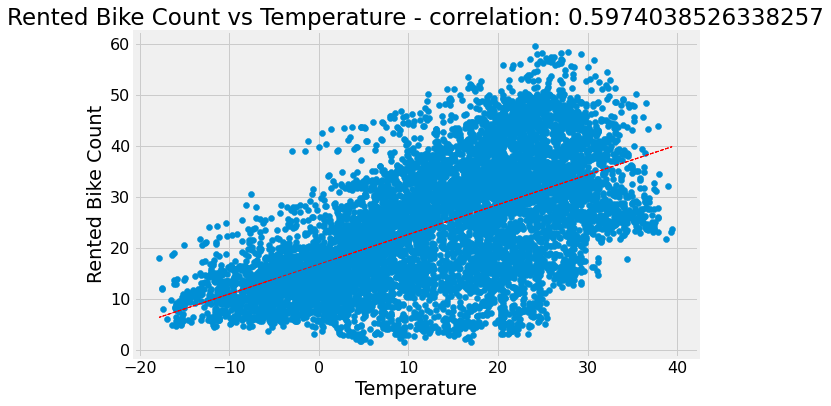

In [109]:
# find the correlation of Temperature with the dependent variable
regression_line_plot(df, col, dependent_variable)

* **From the above plot, we can see a linear trend between Temperature vs Rented bike count**

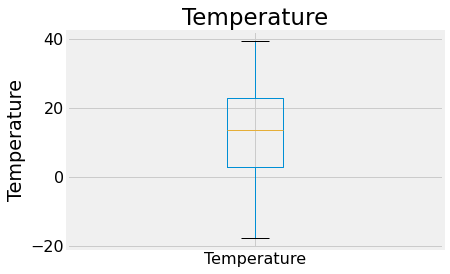

In [110]:
# Check the outliers
df.boxplot(column=col)
plt.ylabel(col)
plt.title(col)
plt.show()

* **There is no outlier present in the data.**

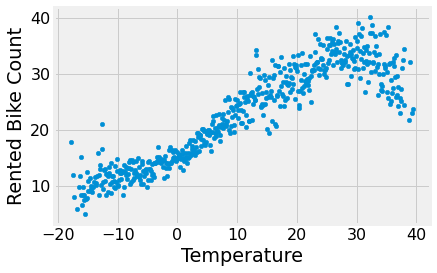

In [111]:
df2 = df.groupby(col, as_index=False).agg({dependent_variable:'mean'})
df2.plot.scatter(x=col, y=dependent_variable)

* **It seems that between 20-30 °C rented bike count increases.**

### Humidity

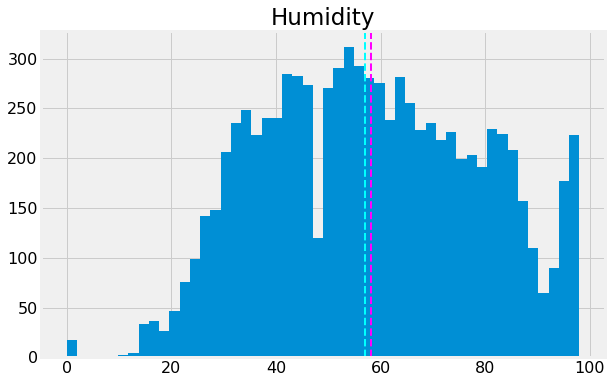

In [112]:
# check the distribution of the column Humidity
col = "Humidity"
histogram(df, col)

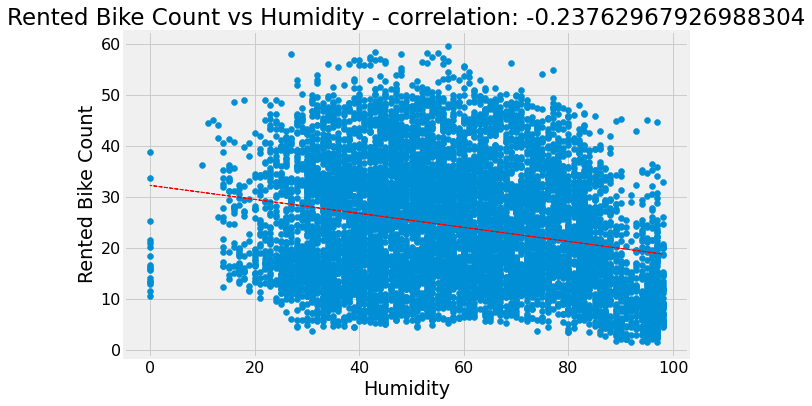

In [113]:
# find the correlation of Humidity with the dependent variable
regression_line_plot(df, col, dependent_variable)

* **There is a slight negative linear relation between Humidity vs Rented bike count.**

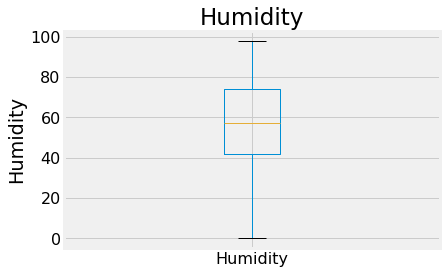

In [114]:
# Check the outliers
df.boxplot(column=col)
plt.ylabel(col)
plt.title(col)
plt.show()

* **There are no outliers for Humidity.**

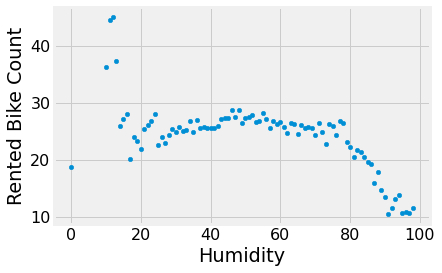

In [115]:
df2 = df.groupby(col, as_index=False).agg({dependent_variable:'mean'})
df2.plot.scatter(x=col, y=dependent_variable)

### Wind speed

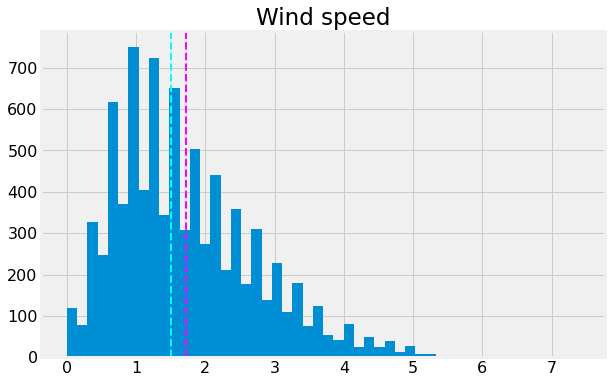

In [116]:
# check the distribution of the column Wind speed
col = "Wind speed"
histogram(df,col)

* **From the above plot, we can see that Wind speed is positively skewed. We can use the Square root technique to make it normally distributed.**

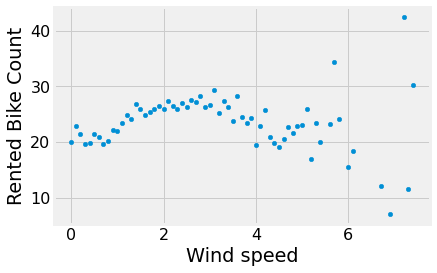

In [117]:
df2 = df.groupby(col, as_index=False).agg({dependent_variable:'mean'})
df2.plot.scatter(x=col, y=dependent_variable)

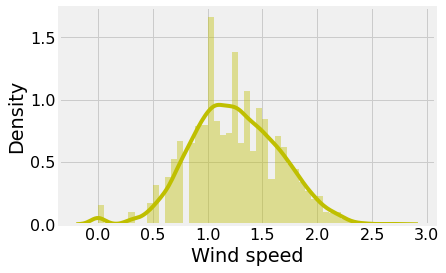

In [118]:
# Square root to make it normally distributed
df['Wind speed'] = df['Wind speed'].apply(lambda x: math.sqrt(x))
sns.distplot(df['Wind speed'],color="y")

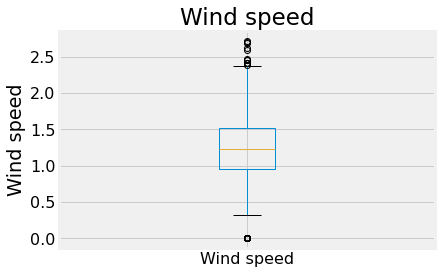

In [119]:
# Check the outliers
df.boxplot(column=col)
plt.ylabel(col)
plt.title(col)
plt.show()

* **There are outliers present in the Wind speed column.**

### Visibility

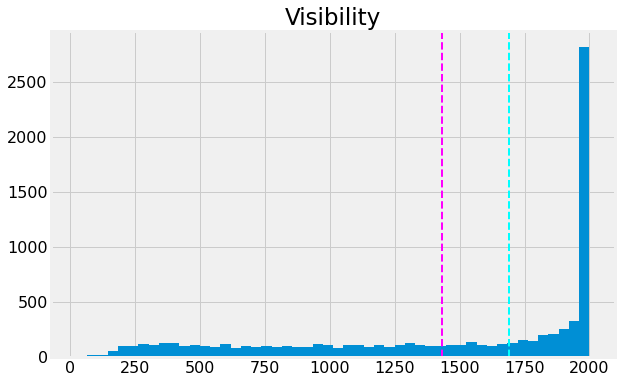

In [120]:
# check the distribution of the column Humidity
col = "Visibility"
histogram(df,col)

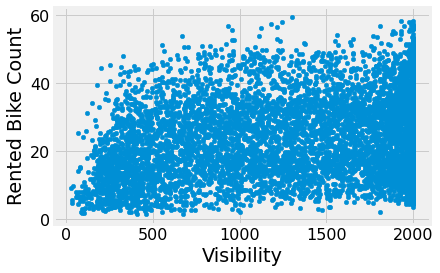

In [121]:
df.plot.scatter(x=col, y=dependent_variable)

In [122]:
print(f"{col} at 2000 is {round(len(df[df[col] == 2000])/df.shape[0]*100,2)}%")

Visibility at 2000 is 25.4%


In [123]:
df[col].describe()

count    8465.000000
mean     1433.873479
std       609.051229
min        27.000000
25%       935.000000
50%      1690.000000
75%      2000.000000
max      2000.000000
Name: Visibility, dtype: float64

* **We can make a new categorical feature from Visibility.**

####isVisible

In [124]:
# create a new feature isVisible
df['isVisible'] = df[col].apply(lambda x: 1 if x==2000 else 0)

In [125]:
df.head()

,Date,Rented Bike Count,Hour,Temperature,Humidity,Wind speed,Visibility,Dew point temperature,Solar Radiation,Rainfall,Snowfall,Seasons,Holiday,month,isWeekend,isWorkingHour,isVisible
0,2017-12-01,15.937377,0,-5.2,37,1.483240,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,12,0,0,1
1,2017-12-01,14.282857,1,-5.5,38,0.894427,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,12,0,0,1
2,2017-12-01,13.152946,2,-6.0,39,1.000000,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,12,0,0,1
3,2017-12-01,10.344080,3,-6.2,40,0.948683,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,12,0,0,1
4,2017-12-01,8.831761,4,-6.0,36,1.516575,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,12,0,0,1


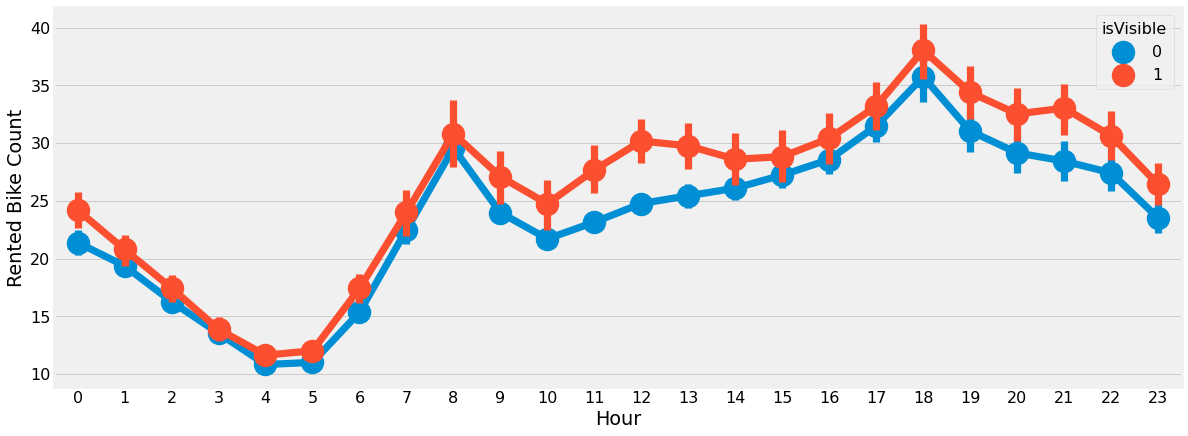

In [126]:
fig,ax=plt.subplots(figsize=(18,7))
sns.pointplot(x = "Hour",y = dependent_variable, hue='isVisible',data = df)

* **It can be seen that for isVisibility 1 rented bike count is slightly higher than 0.**

### Dew point temperature

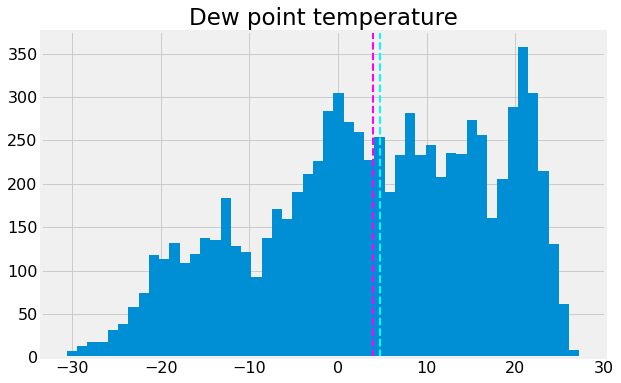

In [127]:
# check the distribution of the column Dew point temperature
col = "Dew point temperature"
histogram(df, col)

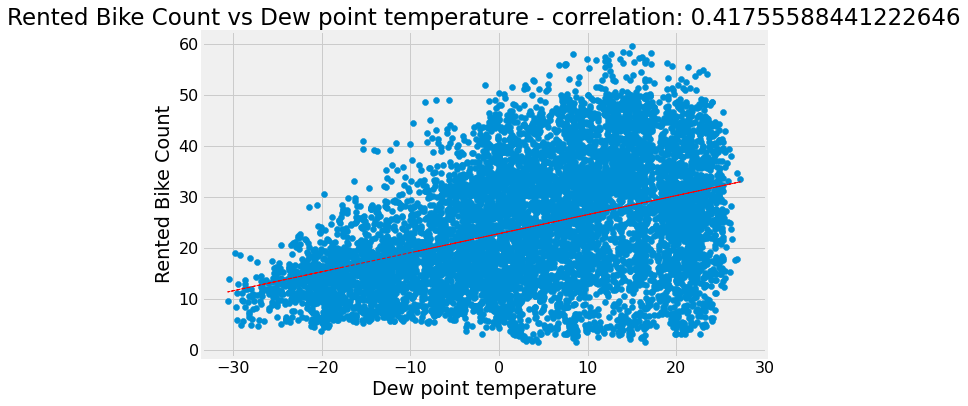

In [128]:
# find the correlation of Dew point temperature with the dependent variable
regression_line_plot(df, col, dependent_variable)

* **From the above plot, we can see a linear trend between Dew point temperature vs Rented bike count**

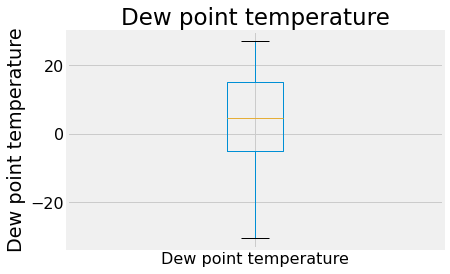

In [129]:
# Check the outliers
df.boxplot(column=col)
plt.ylabel(col)
plt.title(col)
plt.show()

* **There are no outliers present in the data.**

### Solar Radiation

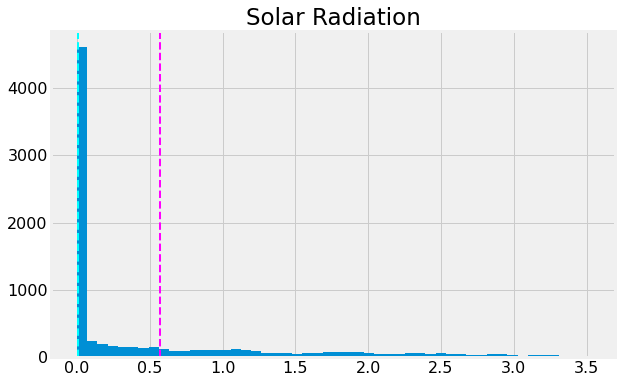

In [130]:
# check the distribution of the column Solar Radiation
col = "Solar Radiation"
histogram(df, col)

In [131]:
print(f"{col} at 0 is {round(len(df[df[col] == 0])/df.shape[0]*100,2)}%")

Solar Radiation at 0 is 49.04%


In [132]:
df[col].describe()

count    8465.000000
mean        0.567868
std         0.868245
min         0.000000
25%         0.000000
50%         0.010000
75%         0.930000
max         3.520000
Name: Solar Radiation, dtype: float64

### Rainfall

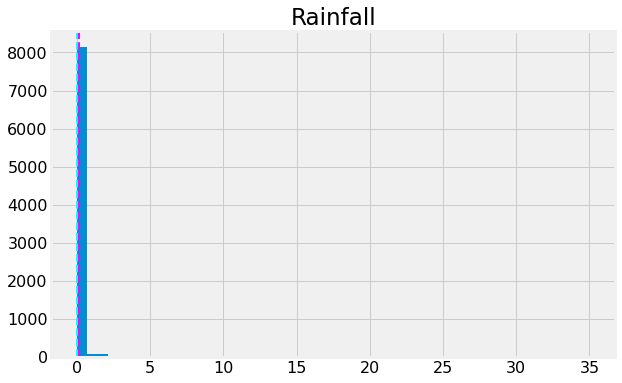

In [133]:
# check the distribution of the column Rainfall
col = "Rainfall"
histogram(df, col)

In [134]:
print(f"No {col} (i.e 0) is {round(len(df[df[col] == 0])/df.shape[0]*100,2)}%")

No Rainfall (i.e 0) is 93.9%


### Snowfall

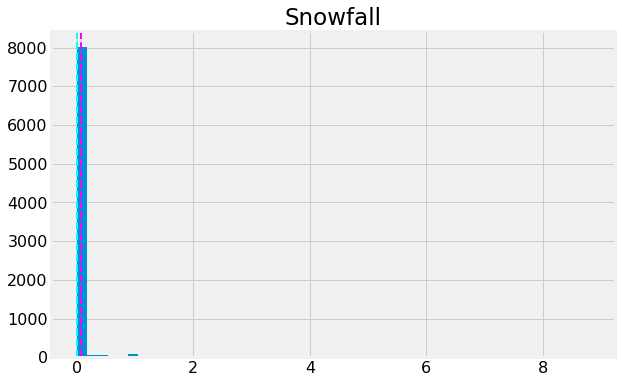

In [135]:
# check the distribution of the column Snowfall
col = "Snowfall"
histogram(df, col)

In [136]:
print(f"No {col} (i.e 0) is {round(len(df[df[col] == 0])/df.shape[0]*100,2)}%")

No Snowfall (i.e 0) is 94.77%


## Encoding

* **There are 2 categorical features Holiday & Seasons which are needed to be encoded.**

In [137]:
encoders_nums = {
    "Seasons":{"Spring":0,"Summer":1, "Autumn": 2, "Winter":3},
    "Holiday": {'Holiday':1, "No Holiday":0}
    }

df = df.replace(encoders_nums)

In [138]:
'''
season_df = pd.get_dummies(df["Seasons"], prefix='season', drop_first=True)
df = pd.concat( [df, season_df], axis=1)
df.head()
'''

'\nseason_df = pd.get_dummies(df["Seasons"], prefix=\'season\', drop_first=True)\ndf = pd.concat( [df, season_df], axis=1)\ndf.head()\n'

In [139]:
df.head()

,Date,Rented Bike Count,Hour,Temperature,Humidity,Wind speed,Visibility,Dew point temperature,Solar Radiation,Rainfall,Snowfall,Seasons,Holiday,month,isWeekend,isWorkingHour,isVisible
0,2017-12-01,15.937377,0,-5.2,37,1.483240,2000,-17.6,0.0,0.0,0.0,3,0,12,0,0,1
1,2017-12-01,14.282857,1,-5.5,38,0.894427,2000,-17.6,0.0,0.0,0.0,3,0,12,0,0,1
2,2017-12-01,13.152946,2,-6.0,39,1.000000,2000,-17.7,0.0,0.0,0.0,3,0,12,0,0,1
3,2017-12-01,10.344080,3,-6.2,40,0.948683,2000,-17.6,0.0,0.0,0.0,3,0,12,0,0,1
4,2017-12-01,8.831761,4,-6.0,36,1.516575,2000,-18.6,0.0,0.0,0.0,3,0,12,0,0,1


## Feature Selection

### Correlation

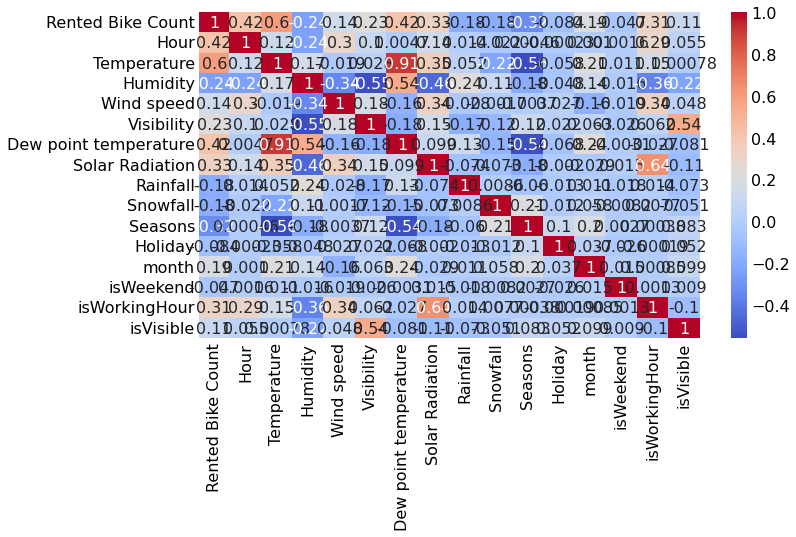

In [140]:
plt.figure(figsize=(10,6))
correlation = df.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')

**From the heatmap**
* **Temperature & Dew point temperature is strongly correlated. So, even if we drop any one of them, it will not affect the data. We drop Dew point temperature.**

In [141]:
df.drop(['Dew point temperature'], axis=1, inplace = True)

### Variance Inflation Factor (VIF)

In [142]:
def calc_vif(X):
    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [143]:
list(df.columns)

['Date',
 'Rented Bike Count',
 'Hour',
 'Temperature',
 'Humidity',
 'Wind speed',
 'Visibility',
 'Solar Radiation',
 'Rainfall',
 'Snowfall',
 'Seasons',
 'Holiday',
 'month',
 'isWeekend',
 'isWorkingHour',
 'isVisible']

In [144]:
feature_columns = ['Visibility','isVisible','Hour','month','Solar Radiation','Wind speed','Rainfall','Snowfall','isWeekend','Holiday','isWorkingHour','Temperature','Humidity','Seasons']

In [145]:
# Remove Wind speed
# feature_columns = ['Hour','isWeekend','Holiday','isWorkingHour','Temperature','Humidity','Seasons']

In [146]:
calc_vif(df[feature_columns])

,variables,VIF
0,Visibility,9.098574
1,isVisible,2.014472
2,Hour,4.483632
3,month,5.867236
4,Solar Radiation,3.627698
5,Wind speed,11.737255
6,Rainfall,1.089532
7,Snowfall,1.145186
8,isWeekend,1.392579
9,Holiday,1.068601


* **Since the value of VIF for all variables is less than 10, we will take all of it.**

### Checking in OLS Model

In [147]:
scaler = MinMaxScaler()       #Transform features by scaling each feature to a given range.
X = scaler.fit_transform(df[feature_columns])
y = df[dependent_variable]
X_df = pd.DataFrame(X, columns =[feature_columns])

In [148]:
X_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Visibility,8465.0,0.713063,0.308693,0.0,0.460213,0.842879,1.000000,1.0
isVisible,8465.0,0.253987,0.435316,0.0,0.000000,0.000000,1.000000,1.0
Hour,8465.0,0.500306,0.300909,0.0,0.260870,0.521739,0.782609,1.0
month,8465.0,0.494453,0.313851,0.0,0.181818,0.454545,0.727273,1.0
Solar Radiation,8465.0,0.161326,0.246661,0.0,0.000000,0.002841,0.264205,1.0
Wind speed,8465.0,0.459628,0.148231,0.0,0.348743,0.450225,0.557504,1.0
Rainfall,8465.0,0.004261,0.032158,0.0,0.000000,0.000000,0.000000,1.0
Snowfall,8465.0,0.008828,0.050462,0.0,0.000000,0.000000,0.000000,1.0
isWeekend,8465.0,0.288364,0.453028,0.0,0.000000,0.000000,1.000000,1.0
Holiday,8465.0,0.048198,0.214198,0.0,0.000000,0.000000,0.000000,1.0


In [149]:
R= ['Wind speed']

In [150]:
wert = RobustScaler()       #Transform features by scaling each feature to a given range.
Q = wert.fit_transform(df[R])
Q_df = pd.DataFrame(Q, columns =[R])

In [151]:
type(Q)

numpy.ndarray

In [152]:
Q_df.reset_index()

,index,Wind speed
0,0,0.455183
1,1,-0.581656
2,2,-0.395753
3,3,-0.486117
4,4,0.513883
...,...,...
8460,8460,0.682712
8461,8461,0.513883
8462,8462,-1.192168
8463,8463,-0.395753


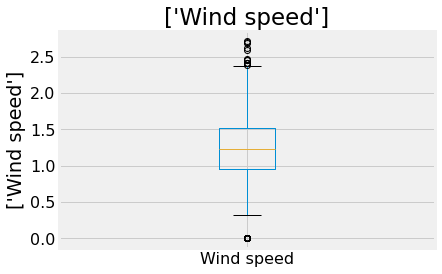

In [156]:
df.boxplot(column=R)
plt.ylabel(R)
plt.title(R)
plt.show()

ValueError: ignored

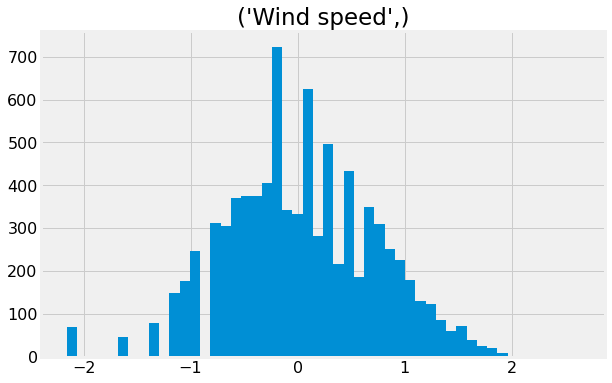

In [154]:
col = "Wind speed"
histogram(Q_df,col)

In [155]:
import statsmodels.api as sm
model= sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:      Rented Bike Count   R-squared (uncentered):                   0.923
Model:                            OLS   Adj. R-squared (uncentered):              0.923
Method:                 Least Squares   F-statistic:                              7240.
Date:                Sun, 08 May 2022   Prob (F-statistic):                        0.00
Time:                        09:25:16   Log-Likelihood:                         -29057.
No. Observations:                8465   AIC:                                  5.814e+04
Df Residuals:                    8451   BIC:                                  5.824e+04
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             4.3945      0.326     13.495      0.000       3.756       5.033
x2            -0.3391      0.229     -1.479      0.139      -0.789       0.110
x3            11.3791      0.299     38.097      0.000      10.794      11.965
x4             4.9319      0.297     16.608      0.000       4.350       5.514
x5            -6.4766      0.537    -12.050      0.000      -7.530      -5.423
x6             3.6340      0.573      6.340      0.000       2.510       4.758
x7           -65.1484      2.623    -24.841      0.000     -70.289     -60.008
x8            -4.2519      1.707     -2.491      0.013      -7.598      -0.906
x9            -1.2672      0.179     -7.072      0.000      -1.618      -0.916
x10           -3.2690      0.384     -8.521      0.000      -4.021      -2.517
x11            3.9594      0.226     17.489      0.000       3.516       4.403
x12           32.1123      0.577     55.657      0.000      30.981      33.243
x13           -8.1971      0.447    -18.331      0.000      -9.074      -7.321
x14           -2.3179      0.272     -8.519      0.000      -2.851      -1.785
==============================================================================
Omnibus:                       82.894   Durbin-Watson:                   0.496
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              138.218
Skew:                           0.006   Prob(JB):                     9.69e-31
Kurtosis:                       3.626   Cond. No.                         52.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

* Since, for x2 (i.e isVisible) p > 0.05 we can remove it.

In [157]:
feature_columns.remove('isVisible')

In [158]:
feature_columns

['Visibility',
 'Hour',
 'month',
 'Solar Radiation',
 'Wind speed',
 'Rainfall',
 'Snowfall',
 'isWeekend',
 'Holiday',
 'isWorkingHour',
 'Temperature',
 'Humidity',
 'Seasons']

In [159]:
X = df[feature_columns]

# Model Training

## Train Test split

In [160]:
#X = df[feature_columns]
#y = df[dependent_variable]

In [161]:
# Splitting the dataset into the Training set and Test set in 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [162]:
# Check the shape of train and dataset
print(f"Total rows in train is {X_train.shape[0]} and test is {X_test.shape[0]}")

Total rows in train is 6772 and test is 1693


In [163]:
# Transforming data
#scaler = MinMaxScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

## LINEAR REGRESSION

In [165]:
# Fitting Multiple Linear Regression to the Training set
regressor = LinearRegression().fit(X_train, y_train)
regressor

LinearRegression()

In [166]:
#check the score
print(f"Regression score for training is {regressor.score(X_train, y_train)}")

Regression score for training is 0.6168500159324759


In [167]:
#check the coefficeint
regressor.coef_

array([ 5.18820748e-04,  4.66347055e-01,  4.76346236e-01, -2.17139219e+00,
       -1.89769888e-01, -1.78499172e+00, -2.99160713e-01, -1.56607757e+00,
       -3.30642947e+00,  3.74593528e+00,  5.32637462e-01, -1.57247053e-01,
       -1.33795682e+00])

In [168]:
#predicted o/p of trained data
y_pred_train = regressor.predict(X_train)         
y_pred_train

array([ 6.64686783,  5.64102093, 24.25669069, ..., 33.39935552,
       22.97782977, 19.64658702])

In [169]:
#predicted o/p of test data
y_pred_test = regressor.predict(X_test)           
y_pred_test

array([15.57706171, 27.44200835, 21.09767009, ..., 29.80621527,
       11.00900966, 27.68122293])

* **Let's check performance metrics for Linear Regression**

In [170]:
model_evaluation_show_and_save(regressor, "Linear Regression", X_test, y_train, y_test, y_pred_train, y_pred_test)

For Train Data: 
MSE  :  54.102567444444134
RMSE  :  7.355444748242225
MAE  :  5.741075402791391
R2  :  0.6168500159324759
Adjusted R2  :  0.6138833990218876
----------------------------------------
For Test Data: 
MSE  :  55.36755943117728
RMSE  :  7.440938074676961
MAE  :  5.736032022603202
R2  :  0.5985976736366321
Adjusted R2  :  0.5954897342425143


In [171]:
pd.DataFrame(model_scores_dict).T

,Test_Adjusted R2,Test_MAE,Test_MSE,Test_R2,Test_RMSE,Train_Adjusted R2,Train_MAE,Train_MSE,Train_R2,Train_RMSE
Linear Regression,0.59549,5.736032,55.367559,0.598598,7.440938,0.613883,5.741075,54.102567,0.61685,7.355445


## LASSO REGRESSION:

In [172]:
lasso = Lasso(alpha=0.001, max_iter=3000)
# Fit the Lasso model
lasso.fit(X_train, y_train)
# Create the model score
print(f"Lasso Regression score for training data is {lasso.score(X_train, y_train)} and test data is {lasso.score(X_test, y_test)}")

Lasso Regression score for training data is 0.616849596687366 and test data is 0.5985731871936674


In [173]:
### Cross validation
from sklearn.model_selection import GridSearchCV
lasso = Lasso()
parameters = {'alpha': [1e-15,1e-13,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1e-1,1,5,10,20,30,40,45,50,55,60,100,0.0014]}
lasso_regressor = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=5)
lasso_regressor.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [1e-15, 1e-13, 1e-10, 1e-08, 1e-05, 0.0001,
                                   0.001, 0.01, 0.1, 1, 5, 10, 20, 30, 40, 45,
                                   50, 55, 60, 100, 0.0014]},
             scoring='neg_mean_squared_error')

In [174]:
print("The best fit alpha value is found out to be :" ,lasso_regressor.best_params_)
print("\nUsing ",lasso_regressor.best_params_, " the negative mean squared error is: ", lasso_regressor.best_score_)

The best fit alpha value is found out to be : {'alpha': 0.01}

Using  {'alpha': 0.01}  the negative mean squared error is:  -54.49435066293819


In [175]:
y_pred_lasso_train = lasso_regressor.predict(X_train)

In [176]:
y_pred_lasso_test = lasso_regressor.predict(X_test)

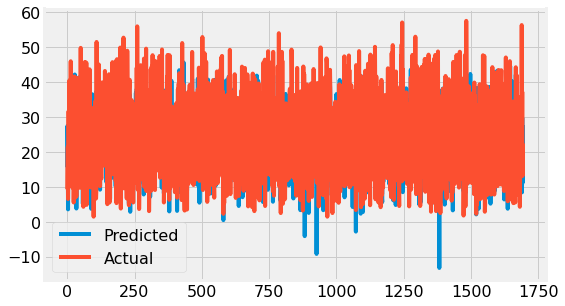

In [177]:
# plot for test data
plt.figure(figsize=(8,5))
plt.plot(y_pred_lasso_test)
plt.plot(np.array(y_test))
plt.legend(["Predicted","Actual"])
plt.show()

In [178]:
model_evaluation_show_and_save(lasso_regressor, "Lasso Regression", X_test, y_train, y_test, y_pred_lasso_train, y_pred_lasso_test)

For Train Data: 
MSE  :  54.10848759477773
RMSE  :  7.355847170433718
MAE  :  5.740135526325352
R2  :  0.6168080899091255
Adjusted R2  :  0.6138411483777488
----------------------------------------
For Test Data: 
MSE  :  55.40640096952273
RMSE  :  7.4435476064523645
MAE  :  5.736105665988648
R2  :  0.5983160812382752
Adjusted R2  :  0.5952059615575709


## RIDGE REGRESSION

In [180]:
ridge= Ridge(alpha=0.01)
#FIT THE MODEL
ridge.fit(X_train,y_train)
#check the score
print(f"Ridge regression score: {ridge.score(X_train, y_train)}")

Ridge regression score: 0.6168500159258459


## DECISION TREE

In [181]:
decision_regressor = DecisionTreeRegressor(criterion='mse', max_depth=7,
                      max_features=7, max_leaf_nodes=100,)
decision_regressor.fit(X_train, y_train)

#get the X_train and X-test value
y_pred_train_d = decision_regressor.predict(X_train)
y_pred_test_d = decision_regressor.predict(X_test)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


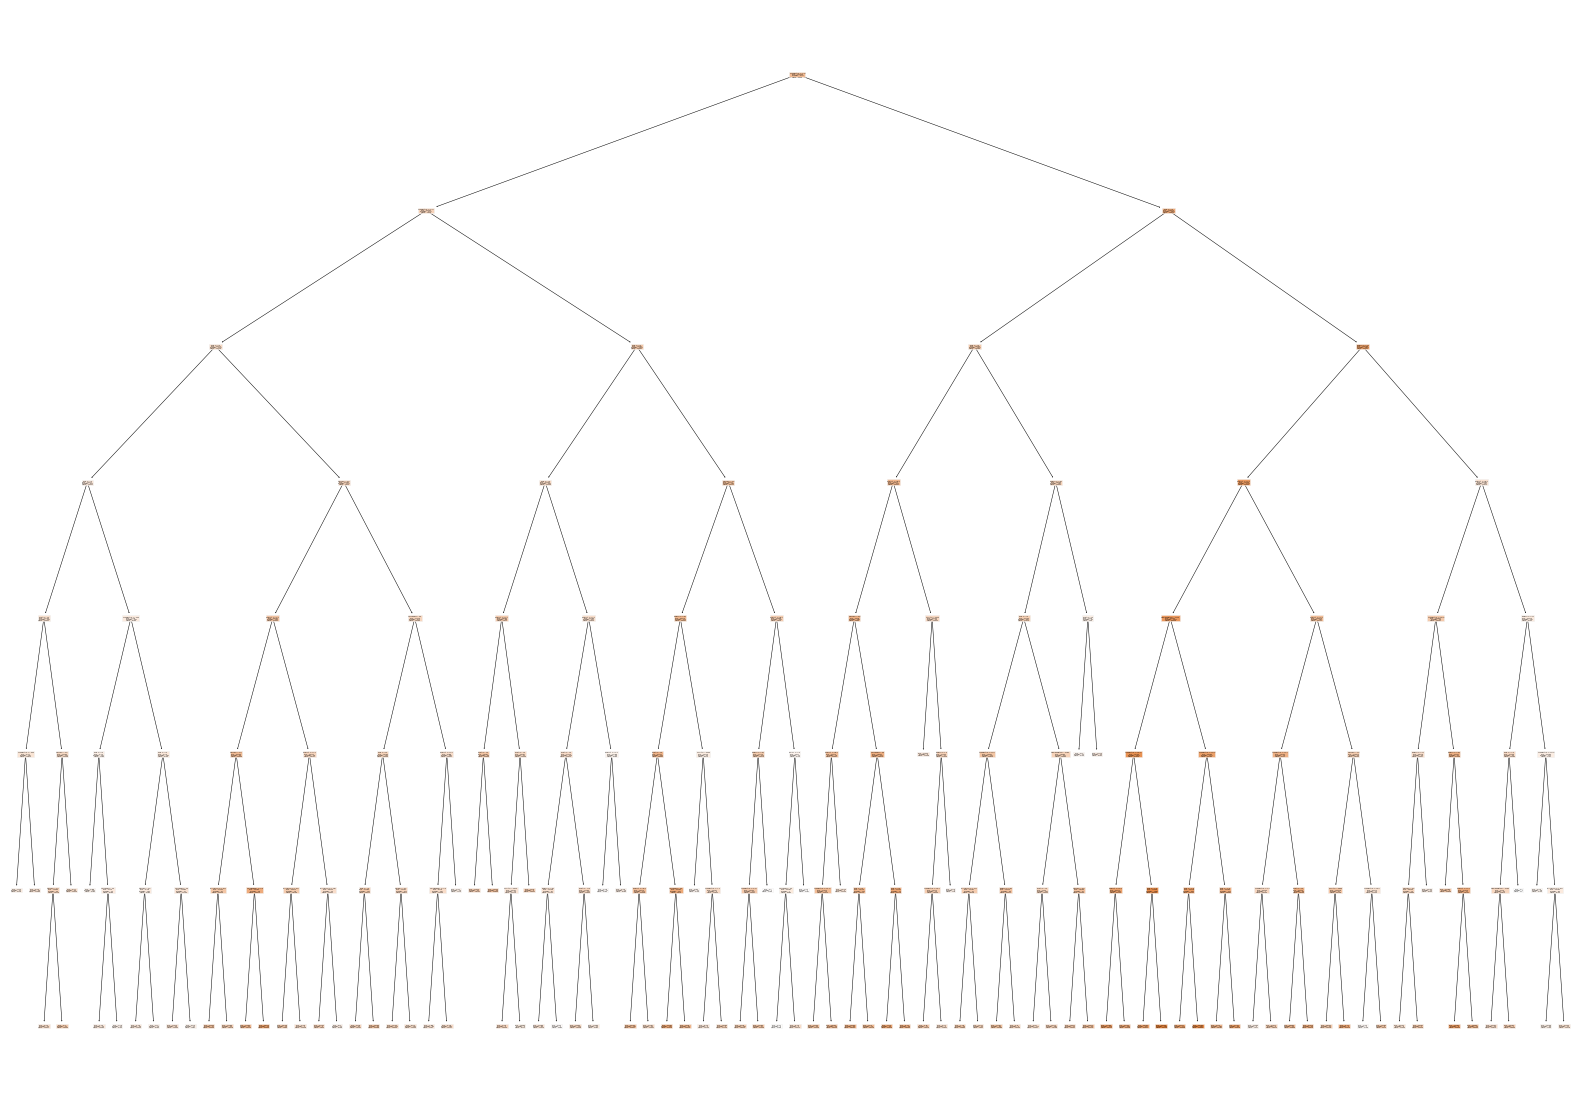

In [182]:
from sklearn import tree
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(decision_regressor, 
                   feature_names=feature_columns,  
                   class_names=dependent_variable,
                   filled=True)

In [183]:
model_evaluation_show_and_save(decision_regressor, "Decision Tree", X_test, y_train, y_test, y_pred_train_d, y_pred_test_d)

For Train Data: 
MSE  :  23.99643351122031
RMSE  :  4.8986154688054775
MAE  :  3.5389464182285497
R2  :  0.8300592087992373
Adjusted R2  :  0.8287434075570634
----------------------------------------
For Test Data: 
MSE  :  31.14850944285963
RMSE  :  5.5810849700447696
MAE  :  3.98578083218798
R2  :  0.7741803272247043
Adjusted R2  :  0.7724318723431802


In [184]:
# Number of trees
n_estimators = [50,80,100]

# Maximum depth of trees
max_depth = [4,6,8]

# Minimum number of samples required to split a node
min_samples_split = [50,100,150]

# Minimum number of samples required at each leaf node
min_samples_leaf = [40,50]

# HYperparameter Grid
param_dict = {'n_estimators' : n_estimators,
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf}

In [185]:
gb_model = GradientBoostingRegressor()

# Grid search

gb_grid = GridSearchCV(estimator=gb_model,
                       param_grid = param_dict,
                       cv = 5, verbose=2)

gb_grid.fit(X_train,y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=50; total time=   0.5s
[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=50; total time=   0.5s
[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=50; total time=   0.5s
[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=50; total time=   0.5s
[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=50; total time=   0.5s
[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=80; total time=   0.8s
[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=80; total time=   0.8s
[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=80; total time=   0.8s
[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=80; total time=   0.8s
[CV] END max_depth=4, min_sam

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'max_depth': [4, 6, 8], 'min_samples_leaf': [40, 50],
                         'min_samples_split': [50, 100, 150],
                         'n_estimators': [50, 80, 100]},
             verbose=2)

In [186]:
gb_grid.best_estimator_

GradientBoostingRegressor(max_depth=8, min_samples_leaf=40,
                          min_samples_split=50)

In [187]:
best_param_dict = {
              'max_depth' : 8,
              'min_samples_split' : 50,
              'min_samples_leaf' : 40}

In [188]:
gb_model = GradientBoostingRegressor(max_depth=8, min_samples_leaf=40,
                          min_samples_split=50)

gb_model.fit(X_train,y_train)

GradientBoostingRegressor(max_depth=8, min_samples_leaf=40,
                          min_samples_split=50)

In [189]:
#gb_optimal_model = gb_grid.best_estimator_

In [190]:
# Making predictions on train and test data
y_pred_train_g_g = gb_model.predict(X_train)
y_pred_g_g= gb_model.predict(X_test)

In [191]:
model_evaluation_show_and_save(gb_model, "Gradient Boosting", X_test, y_train, y_test, y_pred_train_g_g, y_pred_g_g)

For Train Data: 
MSE  :  4.569584385185485
RMSE  :  2.137658622227947
MAE  :  1.415736394207416
R2  :  0.967638574894308
Adjusted R2  :  0.9673880099590049
----------------------------------------
For Test Data: 
MSE  :  10.194692331168664
RMSE  :  3.1929128286203907
MAE  :  1.9590072385650947
R2  :  0.9260907784209539
Adjusted R2  :  0.9255185211961012


## RANDOM FOREST

In [196]:
# Create an instance of the RandomForestRegressor
rf_model = RandomForestRegressor()
rf_model.fit(X_train,y_train)

RandomForestRegressor()

In [197]:
# Making predictions on train and test data
y_pred_train_r = rf_model.predict(X_train)
y_pred_test_r = rf_model.predict(X_test)

In [198]:
model_evaluation_show_and_save(rf_model, "Random Forest", X_test, y_train, y_test, y_pred_train_r, y_pred_test_r)

For Train Data: 
MSE  :  1.29525178347019
RMSE  :  1.1380912896029869
MAE  :  0.7281322832616042
R2  :  0.9908271321742791
Adjusted R2  :  0.9907561093739609
----------------------------------------
For Test Data: 
MSE  :  11.499608583365315
RMSE  :  3.391107279837268
MAE  :  2.102729189908706
R2  :  0.9166304297127507
Adjusted R2  :  0.9159849238082037


* Feature Importance

In [199]:
importances = rf_model.feature_importances_

importance_dict = {'Feature' : list(X_train.columns),
                   'Feature Importance' : importances}

importance_df = pd.DataFrame(importance_dict)

importances = rf_model.feature_importances_
importance_df['Feature Importance'] = round(importance_df['Feature Importance'],2)

In [200]:
importance_df.sort_values(by=['Feature Importance'],ascending=False)

,Feature,Feature Importance
10,Temperature,0.37
1,Hour,0.31
11,Humidity,0.11
5,Rainfall,0.06
12,Seasons,0.04
7,isWeekend,0.03
2,month,0.02
3,Solar Radiation,0.02
0,Visibility,0.01
4,Wind speed,0.01


In [201]:
importtant_feature = ['Temperature','Hour','Humidity','Rainfall']

In [202]:
X_new_train = X_train[importtant_feature]
X_new_train

,Temperature,Hour,Humidity,Rainfall
843,-5.5,3,56,0.0
1705,1.7,1,71,0.0
7033,20.0,1,59,0.0
3655,17.6,7,94,1.0
5679,34.0,15,50,0.0
...,...,...,...,...
4421,17.1,5,66,0.0
8138,8.8,2,81,0.0
4907,27.5,11,31,0.0
3288,9.6,0,31,0.0


In [203]:
X_new_test = X_test[importtant_feature]

In [204]:
rf_new_model = RandomForestRegressor()
rf_new_model.fit(X_new_train,y_train)

RandomForestRegressor()

In [205]:
# Making predictions on train and test data
y_pred_train_r = rf_new_model.predict(X_new_train)
y_pred_test_r = rf_new_model.predict(X_new_test)

In [206]:
print("Train Model: ")
evaluation_metrics(rf_new_model, X_new_train, y_train, y_pred_train_r )

Train Model: 


{'Adjusted R2': 0.9789848566007914,
 'MAE': 1.2106248462172666,
 'MSE': 2.96568338275867,
 'R2': 0.9789972713952969,
 'RMSE': 1.722115960891911}

In [207]:
print("Test Model: ")
evaluation_metrics(rf_new_model, X_new_test, y_test, y_pred_test_r )

Test Model: 


{'Adjusted R2': 0.8167976772279746,
 'MAE': 3.4998381759554227,
 'MSE': 25.210331394507932,
 'R2': 0.8172307796458753,
 'RMSE': 5.020989085280701}

## GRADIENT BOOSTING

In [208]:
# Create an instance of the GradientBoostingRegressor
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train,y_train)

GradientBoostingRegressor()

In [209]:
# Making predictions on train and test data
y_pred_train_g = gb_model.predict(X_train)
y_pred_test_g = gb_model.predict(X_test)

In [210]:
model_evaluation_show_and_save(gb_model, "Gradient Boosting", X_test, y_train, y_test, y_pred_train_g, y_pred_test_g)

For Train Data: 
MSE  :  13.377015469414003
RMSE  :  3.6574602485076997
MAE  :  2.58784185254446
R2  :  0.9052650640056947
Adjusted R2  :  0.9045315594387346
----------------------------------------
For Test Data: 
MSE  :  17.569337218131057
RMSE  :  4.191579322657637
MAE  :  2.925436278299898
R2  :  0.8726262651907835
Adjusted R2  :  0.871640048065995


In [211]:
!pip install shap

     |████████████████████████████████| 564 kB 5.1 MB/s 


In [212]:
import shap

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


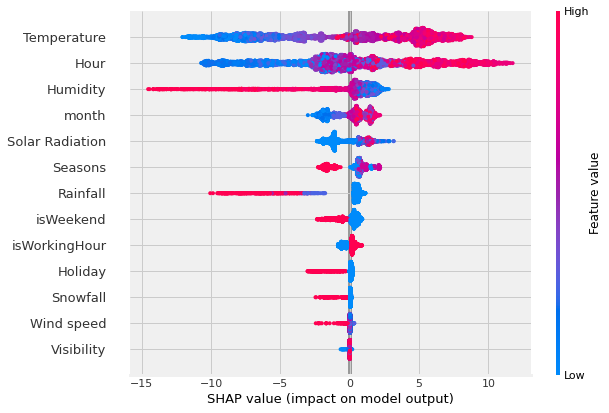

In [213]:
# Create object that can calculate shap values
explainer_train = shap.TreeExplainer(gb_model)

# calculate shap values. This is what we will plot.
shap_values_train = explainer_train.shap_values(X_train)

# make plot.
shap.summary_plot(shap_values_train,X_train,plot_type='dot')
#shap.dependence_plot('Rented Bike Count', shap_values[1], X, interaction_index="Goal Scored")

In [214]:
explainer = shap.Explainer(gb_model)
shap_values = explainer(X_train)
#shap.plots.bar(shap_values_train)

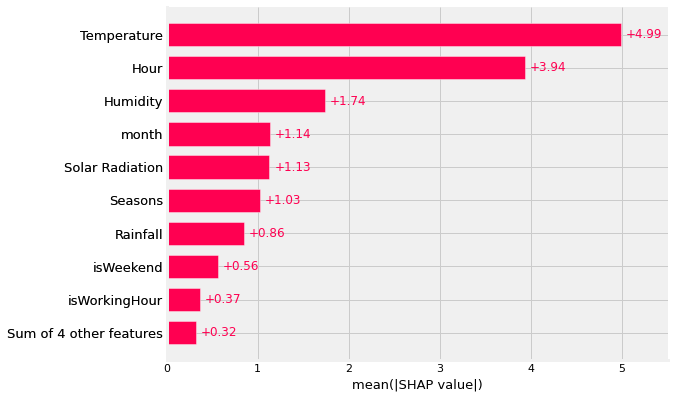

In [215]:
shap.plots.bar(shap_values)

In [216]:
shap.initjs()
shap.force_plot(explainer_train.expected_value, shap_values_train[:,0],X_train.iloc[:,0])